Data loaded successfully. Shape: (721, 9)

First 5 rows:


,Time,3-PGA 30mM,3-PGA 30mM.1,3-PGA/MDX 30mM +2mM Phosphate buffer,3-PGA/MDX 30mM +2mM Phosphate buffer.1,MDX 30mM +2mM Phosphate buffer,MDX 30mM +2mM Phosphate buffer.1,NC (3-PGA 30mM),NC (3-PGA 30mM).1
0,00:01:55,2,0,14,10,23,10,4,9
1,00:03:55,22,0,9,0,0,0,3,9
2,00:05:55,20,16,4,18,17,0,3,9
3,00:07:55,20,9,17,1,20,4,13,13
4,00:09:55,5,11,1,9,10,1,21,8



Column indices available (0-based):
0: Time
1: 3-PGA 30mM
2: 3-PGA 30mM.1
3: 3-PGA/MDX 30mM +2mM Phosphate buffer
4: 3-PGA/MDX 30mM +2mM Phosphate buffer.1
5: MDX 30mM +2mM Phosphate buffer
6: MDX 30mM +2mM Phosphate buffer.1
7: NC (3-PGA 30mM)
8: NC (3-PGA 30mM).1

Selected columns for Plot 1:
Time: Time
Replicates: ['3-PGA 30mM', '3-PGA 30mM.1']

Selected columns for Plot 2:
Time: Time
Replicates: ['NC (3-PGA 30mM)', 'NC (3-PGA 30mM).1']

--- Generating Plot 1 (Replicates from Columns 1 & 2) ---
Plot 1 saved to: /users/aranpurdy/desktop/GIT/gfp_kinetics_plot_1.pdf


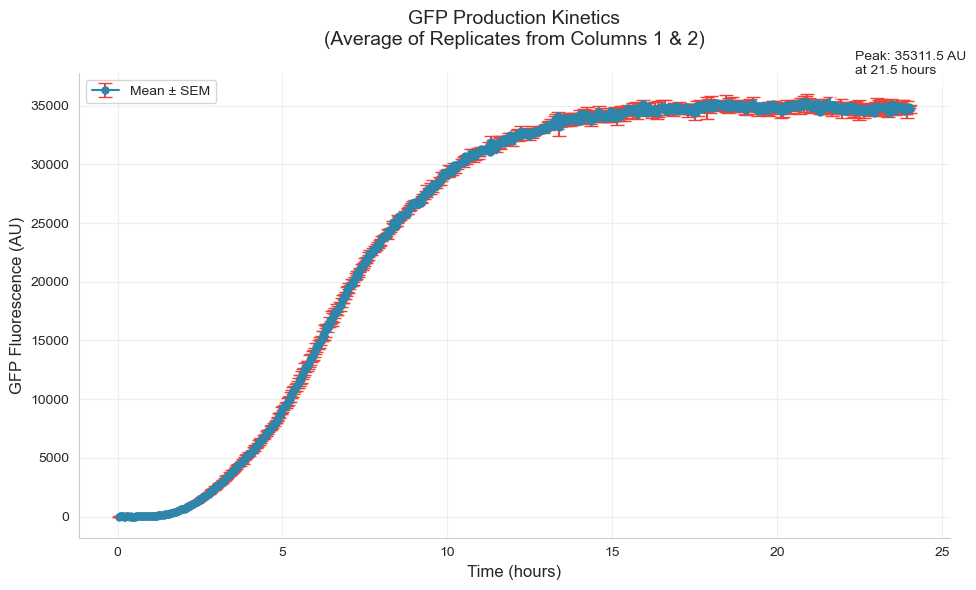


--- Generating Plot 2 (Replicates from Columns 7 & 8) ---
Plot 2 saved to: /users/aranpurdy/desktop/GIT/gfp_kinetics_plot_2.pdf


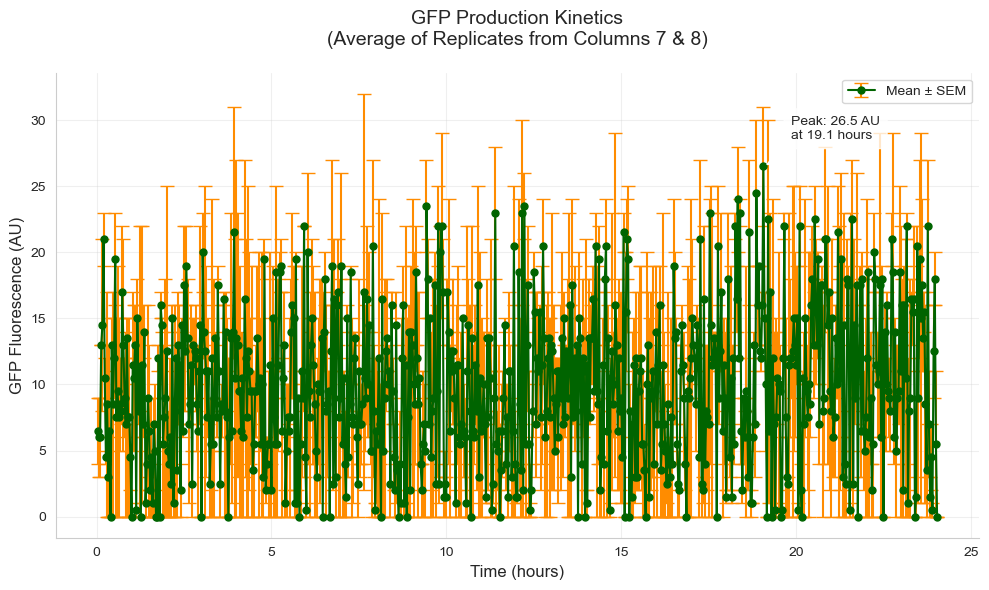


Processed data for Plot 1:


,Time_original,Time_hours,Replicate_1,Replicate_2,Mean,SEM
0,00:01:55,0.031944,2,0,1.0,1.0
1,00:03:55,0.065278,22,0,11.0,11.0
2,00:05:55,0.098611,20,16,18.0,2.0
3,00:07:55,0.131944,20,9,14.5,5.5
4,00:09:55,0.165278,5,11,8.0,3.0



Processed data for Plot 2:


,Time_original,Time_hours,Replicate_3,Replicate_4,Mean,SEM
0,00:01:55,0.031944,4,9,6.5,2.5
1,00:03:55,0.065278,3,9,6.0,3.0
2,00:05:55,0.098611,3,9,6.0,3.0
3,00:07:55,0.131944,13,13,13.0,0.0
4,00:09:55,0.165278,21,8,14.5,6.5


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import time, timedelta
from matplotlib.ticker import FuncFormatter
import os

# --- Configuration ---
FILE_PATH = "PATH/TO/GFP/KINETICS/DATA.xlsx"
SHEET_NAME = "Sheet2"
OUT_DIR = "/PATH/TO/OUTPUT/DIR"

# Create the output directory if it doesn't exist
os.makedirs(OUT_DIR, exist_ok=True)


# Set up plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# 1. Load and inspect the Excel file
try:
    df = pd.read_excel(FILE_PATH, sheet_name=SHEET_NAME, engine='openpyxl')
    print("Data loaded successfully. Shape:", df.shape)
    print("\nFirst 5 rows:")
    display(df.head())
except Exception as e:
    print(f"Error loading file: {e}")
    raise

# 2. Verify data structure
if df.shape[1] < 3: # Check for at least 3 columns for time + 2 replicates
    raise ValueError("Dataset needs at least 3 columns for a time column and one pair of replicates.")

# Let user confirm column selection
print("\nColumn indices available (0-based):")
for idx, col in enumerate(df.columns):
    print(f"{idx}: {col}")

# 3. Select columns by position (update these numbers!)
time_col_idx = 0    # Time column (HH:MM:SS format)
rep_cols_idx_1 = [1, 2]  # First set of two replicate columns
rep_cols_idx_2 = [7, 8]  # Second set of two replicate columns

# Verify selections and prepare dataframes for plotting
try:
    time_values = df.iloc[:, time_col_idx]
    
    # Plot 1 Data
    rep_values_1 = df.iloc[:, rep_cols_idx_1]
    print("\nSelected columns for Plot 1:")
    print("Time:", df.columns[time_col_idx])
    print("Replicates:", [df.columns[i] for i in rep_cols_idx_1])

    # Plot 2 Data (conditional on enough columns)
    if df.shape[1] >= 9:
        rep_values_2 = df.iloc[:, rep_cols_idx_2]
        print("\nSelected columns for Plot 2:")
        print("Time:", df.columns[time_col_idx])
        print("Replicates:", [df.columns[i] for i in rep_cols_idx_2])
    else:
        rep_values_2 = None
        print("\nSkipping Plot 2: Not enough columns in the data file for columns 7 & 8.")

except IndexError:
    print("\nERROR: Column indices out of range!")
    print(f"Your dataset has {df.shape[1]} columns (0-{df.shape[1]-1})")
    raise

# 4. Convert time to total seconds (works for strings, datetime.time, and timedelta objects)
def convert_to_seconds(t):
    if isinstance(t, str):
        parts = str(t).split(':')
        if len(parts) == 3:
            h, m, s = map(float, parts)
            return h * 3600 + m * 60 + s
        return 0
    elif isinstance(t, time):
        return t.hour * 3600 + t.minute * 60 + t.second
    elif isinstance(t, timedelta):
        return t.total_seconds()
    elif pd.isna(t):
        return None
    return t

# Apply the conversion, ignoring potential None values from missing times
time_seconds = np.array([convert_to_seconds(t) for t in time_values if convert_to_seconds(t) is not None])

# Filter out corresponding data points where time was missing
valid_time_indices = [i for i, t in enumerate(time_values) if not pd.isna(t)]
rep_values_1 = rep_values_1.iloc[valid_time_indices]
if rep_values_2 is not None:
    rep_values_2 = rep_values_2.iloc[valid_time_indices]


# Convert seconds to hours for plotting
time_hours = time_seconds / 3600

# 5. Calculate statistics for all sets of replicates
gfp_mean_1 = rep_values_1.mean(axis=1)
gfp_sem_1 = rep_values_1.sem(axis=1)

if rep_values_2 is not None:
    gfp_mean_2 = rep_values_2.mean(axis=1)
    gfp_sem_2 = rep_values_2.sem(axis=1)

# --- PLOT 1 ---
print("\n--- Generating Plot 1 (Replicates from Columns 1 & 2) ---")
plt.figure(figsize=(10, 6))
plt.errorbar(x=time_hours, y=gfp_mean_1, yerr=gfp_sem_1, fmt='-o', color='#2E86AB',
             ecolor='#F24236', capsize=5, linewidth=1.5, markersize=5, label='Mean ± SEM')

plt.xlabel('Time (hours)', fontsize=12)
plt.ylabel('GFP Fluorescence (AU)', fontsize=12)
plt.title('GFP Production Kinetics\n(Average of Replicates from Columns 1 & 2)', fontsize=14, pad=20)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

if not gfp_mean_1.empty:
    max_idx = gfp_mean_1.idxmax()
    max_time_hour = time_hours[rep_values_1.index.get_loc(max_idx)]
    max_gfp_mean = gfp_mean_1[max_idx]
    plt.annotate(f'Peak: {max_gfp_mean:.1f} AU\nat {max_time_hour:.1f} hours',
                 xy=(max_time_hour, max_gfp_mean), xytext=(20, 20), textcoords='offset points',
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8),
                 arrowprops=dict(arrowstyle='->'))

sns.despine()
plt.tight_layout()

# Save the plot
plot1_path = os.path.join(OUT_DIR, 'gfp_kinetics_plot_1.pdf')
plt.savefig(plot1_path, dpi=300, bbox_inches='tight')
print(f"Plot 1 saved to: {plot1_path}")
plt.show()


# --- PLOT 2 ---
if rep_values_2 is not None:
    print("\n--- Generating Plot 2 (Replicates from Columns 7 & 8) ---")
    plt.figure(figsize=(10, 6))
    plt.errorbar(x=time_hours, y=gfp_mean_2, yerr=gfp_sem_2, fmt='-o', color='#006400',
                 ecolor='#FF8C00', capsize=5, linewidth=1.5, markersize=5, label='Mean ± SEM')

    plt.xlabel('Time (hours)', fontsize=12)
    plt.ylabel('GFP Fluorescence (AU)', fontsize=12)
    plt.title('GFP Production Kinetics\n(Average of Replicates from Columns 7 & 8)', fontsize=14, pad=20)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)

    if not gfp_mean_2.empty:
        max_idx = gfp_mean_2.idxmax()
        max_time_hour = time_hours[rep_values_2.index.get_loc(max_idx)]
        max_gfp_mean = gfp_mean_2[max_idx]
        plt.annotate(f'Peak: {max_gfp_mean:.1f} AU\nat {max_time_hour:.1f} hours',
                     xy=(max_time_hour, max_gfp_mean), xytext=(20, 20), textcoords='offset points',
                     bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8),
                     arrowprops=dict(arrowstyle='->'))

    sns.despine()
    plt.tight_layout()
    
    # Save the plot
    plot2_path = os.path.join(OUT_DIR, 'gfp_kinetics_plot_2.pdf')
    plt.savefig(plot2_path, dpi=300, bbox_inches='tight')
    print(f"Plot 2 saved to: {plot2_path}")
    plt.show()


# Show the processed data for the first plot
print("\nProcessed data for Plot 1:")
result_df_1 = pd.DataFrame({
    'Time_original': time_values[valid_time_indices],
    'Time_hours': time_hours,
    'Replicate_1': rep_values_1.iloc[:, 0].values,
    'Replicate_2': rep_values_1.iloc[:, 1].values,
    'Mean': gfp_mean_1.values,
    'SEM': gfp_sem_1.values
})
display(result_df_1.head())

# Show the processed data for the second plot
if rep_values_2 is not None:
    print("\nProcessed data for Plot 2:")
    result_df_2 = pd.DataFrame({
        'Time_original': time_values[valid_time_indices],
        'Time_hours': time_hours,
        'Replicate_3': rep_values_2.iloc[:, 0].values,
        'Replicate_4': rep_values_2.iloc[:, 1].values,
        'Mean': gfp_mean_2.values,
        'SEM': gfp_sem_2.values
    })
    display(result_df_2.head())


In [11]:
# =============================================================================
# 1. FILE AND COLUMN CONFIGURATION
# =============================================================================

# Path to your input data file (e.g., CSV or Excel)
INPUT_FILE_PATH = "users/aranpurdy/desktop/GIT/Dataset_kinetics"

# --- Column Selection by Number ---
# Specify the column NUMBERS for your time values and replicate data.
# Use 0-based indexing (the very first column is 0, the second is 1, etc.).

# The number of the column that contains your time data
TIME_COLUMN_INDEX = 0

# A list of the column numbers for your replicate samples
REPLICATE_COLUMN_INDICES = [1, 2] # Example: Selects the 2nd, 3rd, and 4th columns


# =============================================================================
# 2. PLOT CUSTOMIZATION
# =============================================================================

PLOT_TITLE = "GFP Production Kinetics Over 24 hours"
X_AXIS_LABEL = "Time (hours)"
Y_AXIS_LABEL = "GFP Fluorescence (AU)"
LEGEND_LABEL = "Mean ± SEM"


# =============================================================================
# 3. OUTPUT CONFIGURATION
# =============================================================================

# Path and filename for the saved plot. Set to None to disable saving.
OUTPUT_FILENAME = "/users/aranpur/desktop/GIT/GFP.png"


print("✓ Configuration loaded successfully.")

✓ Configuration loaded successfully.


In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime

def convert_to_hours(time_val):
    """Converts a value to total hours if it's a datetime.time object."""
    if isinstance(time_val, datetime.time):
        return time_val.hour + time_val.minute / 60 + time_val.second / 3600
    try:
        return float(time_val)
    except (ValueError, TypeError):
        return np.nan

def generate_kinetics_plot():
    """
    Loads data, calculates statistics, and generates a line plot with error bars
    matching the specified style.
    """
    # --- 1. Load Data ---
    print(f"Attempting to load data from: {INPUT_FILE_PATH}")
    try:
        if INPUT_FILE_PATH.endswith('.csv'):
            df = pd.read_csv(INPUT_FILE_PATH)
        else:
            df = pd.read_excel(INPUT_FILE_PATH)
        print("✓ Data loaded successfully.")
    except Exception as e:
        print(f"✗ ERROR: Could not load data. Reason: {e}")
        return

    # --- 2. Validate and Select Columns ---
    try:
        max_col_index = df.shape[1] - 1
        all_indices = [TIME_COLUMN_INDEX] + REPLICATE_COLUMN_INDICES
        if any(i > max_col_index for i in all_indices):
            raise IndexError("One or more column indices are out of range.")

        time_data = df.iloc[:, TIME_COLUMN_INDEX].apply(convert_to_hours)
        replicate_data = df.iloc[:, REPLICATE_COLUMN_INDICES]
        
        valid_indices = time_data.dropna().index
        time_data = time_data.loc[valid_indices]
        replicate_data = replicate_data.loc[valid_indices]
        print("✓ Columns selected and validated.")
    except Exception as e:
        print(f"✗ ERROR: Could not select or validate columns. Reason: {e}")
        return

    # --- 3. Calculate Statistics ---
    print("Calculating mean and standard error...")
    mean_values = replicate_data.mean(axis=1)
    sem_values = replicate_data.sem(axis=1)
        
    # --- 4. Generate Plot ---
    print("Generating plot...")
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(12, 8))

    # <<< MODIFIED: Colors are now defined here instead of in Cell 1 >>>
    ax.errorbar(
        x=time_data,
        y=mean_values,
        yerr=sem_values,
        fmt='-o',
        color='#2E86AB',        # Color for the line and markers
        ecolor='#F24236',       # Color for the error bars
        capsize=5,
        linewidth=1.5,
        markersize=5,
        label=LEGEND_LABEL
    )
    
    # --- 5. Customize Plot ---
    ax.set_title(PLOT_TITLE, fontsize=20, pad=20)
    ax.set_xlabel(X_AXIS_LABEL, fontsize=14)
    ax.set_ylabel(Y_AXIS_LABEL, fontsize=14)
    
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
    sns.despine(ax=ax)
    
    ax.legend(loc='upper left', fontsize=12)
    
    # --- 6. Save and Show ---
    if OUTPUT_FILENAME:
        try:
            output_dir = os.path.dirname(OUTPUT_FILENAME)
            if output_dir: os.makedirs(output_dir, exist_ok=True)
            plt.savefig(OUTPUT_FILENAME, dpi=300, bbox_inches='tight')
            print(f"✓ Plot saved to: {OUTPUT_FILENAME}")
        except Exception as e:
            print(f"✗ ERROR: Could not save the plot. Reason: {e}")
            
    plt.show()

# --- Run the main function ---
if __name__ == "__main__":
    generate_kinetics_plot()

Attempting to load data from: users/aranpurdy/desktop/GIT/Dataset_kinetics
✗ ERROR: Could not load data. Reason: [Errno 2] No such file or directory: 'users/aranpurdy/desktop/GIT/Dataset_kinetics'
